In [1]:
!mkdir MRI_dataset
%cd MRI_dataset

mkdir: cannot create directory ‘MRI_dataset’: File exists
/content/MRI_dataset


In [2]:
!unzip /content/MRI_dataset/MRI_scans.zip -d /content/MRI_dataset/MRI_scans

unzip:  cannot find or open /content/MRI_dataset/MRI_scans.zip, /content/MRI_dataset/MRI_scans.zip.zip or /content/MRI_dataset/MRI_scans.zip.ZIP.


In [10]:
!rm /content/MRI_dataset/MRI_scans.zip

shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory


In [4]:
!pip install tensorflow
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns
import random
from PIL import Image
from sklearn.model_selection import  train_test_split
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPool2D

In [5]:
import shutil
import random

In [6]:
# Define source dataset folder
dataset_path = "/content/MRI_dataset/MRI_scans"

# Define output paths for train and test datasets
train_dir = "/content/MRI_dataset/train"
test_dir = "/content/MRI_dataset/test"

# Create train & test directories if they don’t exist
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

In [4]:
# Train-test split ratio
test_size = 0.2  # 20% data for testing

# Loop through each subfolder (class)
for folder in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, folder)

    if os.path.isdir(class_path):  # Ensure it's a directory
        images = os.listdir(class_path)
        train_images, test_images = train_test_split(images, test_size=test_size, random_state=42)

        # Create subdirectories in train and test folders
        os.makedirs(os.path.join(train_dir, folder), exist_ok=True)
        os.makedirs(os.path.join(test_dir, folder), exist_ok=True)

        # Move images to train & test folders
        for img in train_images:
            shutil.move(os.path.join(class_path, img), os.path.join(train_dir, folder, img))

        for img in test_images:
            shutil.move(os.path.join(class_path, img), os.path.join(test_dir, folder, img))

print("✅ Train-test split completed successfully!")

✅ Train-test split completed successfully!


In [7]:
print("Train Set Folders:", os.listdir(train_dir))
print("Test Set Folders:", os.listdir(test_dir))

Train Set Folders: ['2', '3', '1', '0']
Test Set Folders: ['healthy', 'meningioma', 'glioma', 'pituitary']


In [6]:
# Define the path to the train folder
train_path = "/content/MRI_dataset/train"

# Mapping of old folder names to new names
rename_mapping = {
    "glioma": "3",
    "pituitary": "2",
    "meningioma": "1",
    "healthy": "0"
}

# Rename the folders
for old_name, new_name in rename_mapping.items():
    old_path = os.path.join(train_path, old_name)
    new_path = os.path.join(train_path, new_name)

    if os.path.exists(old_path):
        os.rename(old_path, new_path)
        print(f"Renamed {old_name} -> {new_name}")
    else:
        print(f"Folder {old_name} not found!")

print("✅ Renaming completed!")

Renamed glioma -> 3
Renamed pituitary -> 2
Renamed meningioma -> 1
Renamed healthy -> 0
✅ Renaming completed!


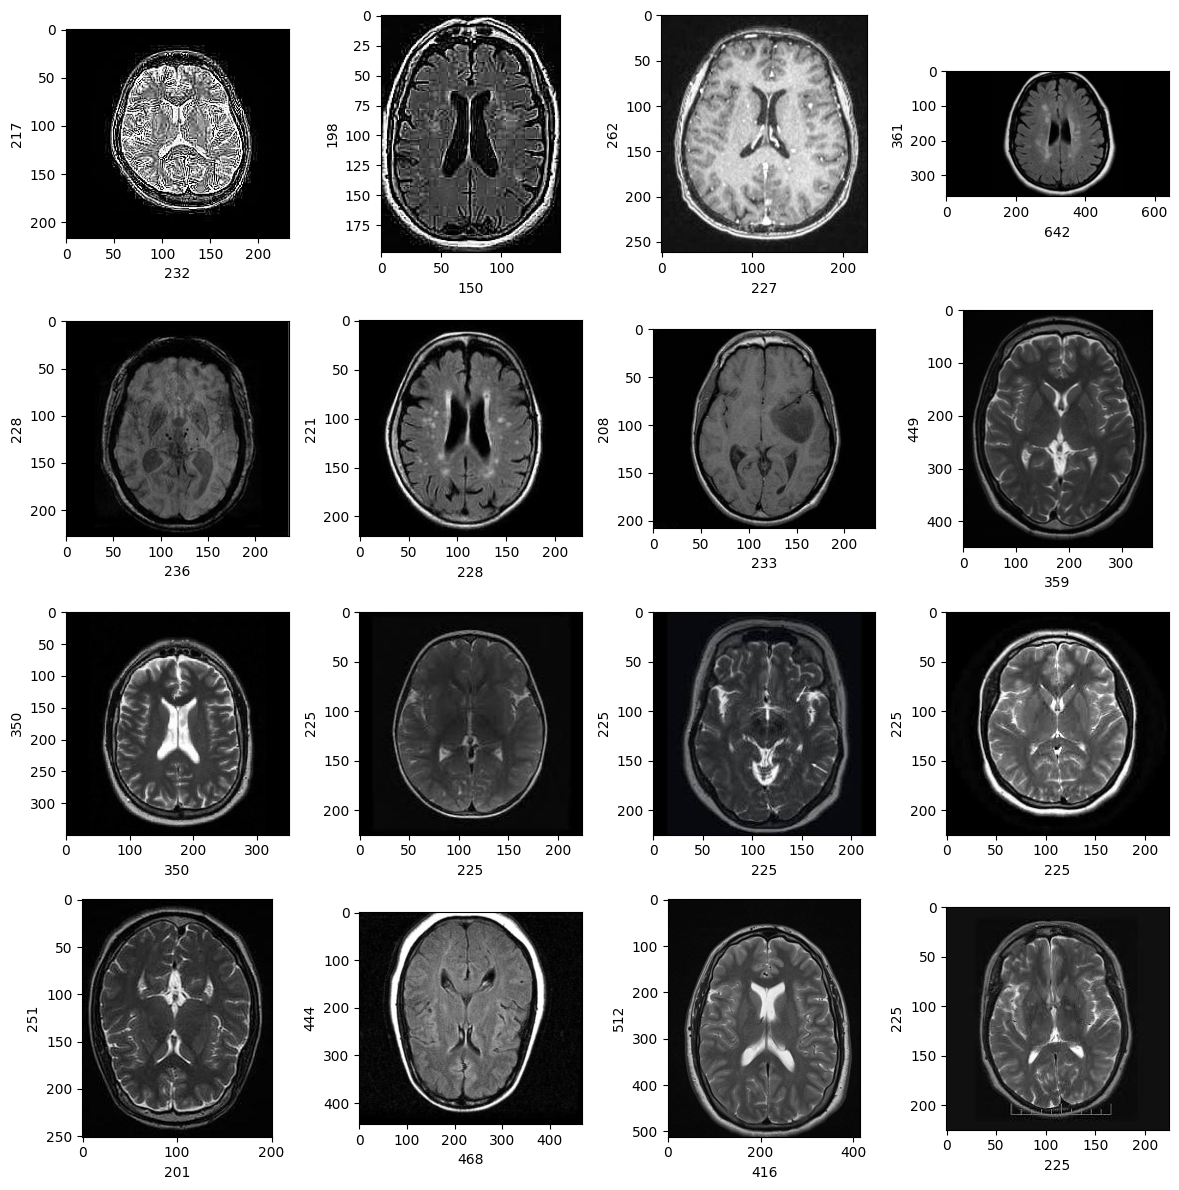

In [8]:
plt.figure(figsize=(12,12))
path = "/content/MRI_dataset/train/0"
for i in range(1,17):
    plt.subplot(4,4,i)
    plt.tight_layout()
    rand_img = imread(path +'/'+ random.choice(sorted(os.listdir(path))))
    plt.imshow(rand_img)
    plt.xlabel(rand_img.shape[1], fontsize = 10)#width of image
    plt.ylabel(rand_img.shape[0], fontsize = 10)#height of image

In [9]:
dim1 = []
dim2 = []

for i in range(0,4):
    labels = "/content/MRI_dataset/train" + '/{0}'.format(i)
    image_path = os.listdir(labels)
    for x in image_path:
        img = imread(labels + '/' + x)
        dim1.append(img.shape[0])
        dim2.append(img.shape[1])

In [10]:
print("Dimension 1 Mean : ",np.mean(dim1), " Dimension 2 Mean : ",np.mean(dim2))

Dimension 1 Mean :  448.29677763930925  Dimension 2 Mean :  446.05501157201354


In [11]:
images = []
label_id = []

for i in range(0, 4):
    labels = '/content/MRI_dataset/train' + '/{0}'.format(i)
    image_path = os.listdir(labels)
    for x in image_path:
        try:
            img = Image.open(labels + '/' + x)
            img = img.resize((50, 50))
            img = np.array(img)
            images.append(img)
            label_id.append(i) # Append label for each image
        except (IOError, OSError) as e:
            print(f"Error loading image {x}: {e}")

print(f"Number of images loaded: {len(images)}")
print(f"Number of labels: {len(label_id)}")

Number of images loaded: 5617
Number of labels: 5617


In [12]:
images = np.array(images)
images = images/255

label_id = np.array(label_id)
label_id.shape

images.shape

label_counts = pd.DataFrame(label_id).value_counts()
label_counts.head()

,count
0,
0,1600
2,1405
1,1316
3,1296


In [13]:
#Splitting the data
x_train, x_val, y_train, y_val = train_test_split(images, label_id , test_size = 0.2, random_state = 42)

from sklearn.model_selection import train_test_split

print(f"x_train shape: {x_train.shape}, y_train shape: {y_train.shape}")
print(f"x_val shape: {x_val.shape}, y_val shape: {y_val.shape}")


y_train_cat = to_categorical(y_train)
y_val_cat = to_categorical(y_val)

# Reshape x_train and x_val to include the channel dimension before fitting the model
x_train = x_train.reshape(-1, 50, 50, 1)  # Reshape to (num_samples, 50, 50, 1)
x_val = x_val.reshape(-1, 50, 50, 1)    # Reshape to (num_samples, 50, 50, 1)


# Ensure x_train and y_train have the same number of samples before fitting
min_samples = min(x_train.shape[0], y_train.shape[0])  # Get the minimum number of samples
x_train = x_train[:min_samples]
y_train = y_train[:min_samples]

# Regenerate validation data using the adjusted x_train and y_train
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

print(f"Final x_train shape: {x_train.shape}, Final y_train shape: {y_train.shape}")
print(f"Final x_val shape: {x_val.shape}, Final y_val shape: {y_val.shape}")

x_train shape: (4493, 50, 50, 3), y_train shape: (4493,)
x_val shape: (1124, 50, 50, 3), y_val shape: (1124,)
Final x_train shape: (3594, 50, 50, 1), Final y_train shape: (3594,)
Final x_val shape: (899, 50, 50, 1), Final y_val shape: (899,)


In [14]:
#Reshape x_train and x_val to include the channel dimension
x_train = x_train.reshape(-1, 50, 50, 1) # Reshape to (num_samples, 50, 50, 1)
x_val = x_val.reshape(-1, 50, 50, 1)   # Reshape to (num_samples, 50, 50, 1)


model = Sequential()

# Update input_shape to (50, 50, 1)
model.add(Conv2D(filters = 64, kernel_size = (3,3), input_shape = (50, 50, 1), activation = 'relu', padding = 'same'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.5))

model.add(Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation = 'softmax'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [15]:
model.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 50, 50, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 25, 25, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 25, 25, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 23, 23, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 11, 11, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 11, 11, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 7744)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         991,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,029,444 (3.93 MB)

 Trainable params: 1,029,444 (3.93 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
min_samples = min(len(x_train), len(y_train))
x_train = x_train[:min_samples]
y_train = y_train[:min_samples]

print(f"Final x_train shape: {x_train.shape}, Final y_train shape: {y_train.shape}")

Final x_train shape: (3594, 50, 50, 1), Final y_train shape: (3594,)


In [17]:
!pip install wandb -q
!pip install --upgrade wandb tensorflow

fb531ee1525853556593582f90635f769689d00e

In [18]:
import wandb
wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: ahiron_ug_24 (ahiron_ug_24-nit-silchar) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [ ]:
!pip install wandb --upgrade  # Ensure wandb is upgraded

import wandb
from wandb.integration.keras import WandbMetricsLogger, WandbModelCheckpoint  # Import necessary callbacks

In [70]:
wandb.init(project="ML HCK MRI", name="experiment_4")

In [ ]:


# Initialize callbacks
metrics_logger = WandbMetricsLogger()  # For logging metrics
# Updated filepath to ensure it's within the current working directory
model_checkpoint = WandbModelCheckpoint(filepath='./model_{epoch:02d}.h5',  # Save model checkpoints in the current directory
                                      monitor='val_accuracy',
                                      save_best_only=False,  # Change to False to save checkpoints for all epochs
                                      save_weights_only=False)  # Save the entire model, not just weights

model.fit(
    x_train, y_train,
    epochs=30,
    batch_size=128,
    validation_data=(x_val, y_val),
    callbacks=[metrics_logger, model_checkpoint]  # Use the initialized callbacks
)



Epoch 1/30
25/29 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8375 - loss: 0.3905

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.8365 - loss: 0.3912 - val_accuracy: 0.2581 - val_loss: 2.7534
Epoch 2/30
25/29 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8275 - loss: 0.4195

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.8273 - loss: 0.4180 - val_accuracy: 0.2547 - val_loss: 2.6870
Epoch 3/30
25/29 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8354 - loss: 0.3883

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.8350 - loss: 0.3883 - val_accuracy: 0.2570 - val_loss: 2.7853
Epoch 4/30
25/29 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8298 - loss: 0.4134

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.8299 - loss: 0.4117 - val_accuracy: 0.2581 - val_loss: 2.8106
Epoch 5/30
28/29 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8162 - loss: 0.4068

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.8165 - loss: 0.4066 - val_accuracy: 0.2570 - val_loss: 2.8264
Epoch 6/30
27/29 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8362 - loss: 0.3794

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.8359 - loss: 0.3806 - val_accuracy: 0.2481 - val_loss: 2.7574
Epoch 7/30
25/29 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8385 - loss: 0.3878

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.8370 - loss: 0.3900 - val_accuracy: 0.2581 - val_loss: 2.7592
Epoch 8/30
25/29 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8453 - loss: 0.3804

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.8450 - loss: 0.3797 - val_accuracy: 0.2614 - val_loss: 2.8242
Epoch 9/30
25/29 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8380 - loss: 0.3953

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.8374 - loss: 0.3947 - val_accuracy: 0.2558 - val_loss: 2.8209
Epoch 10/30
25/29 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8350 - loss: 0.3760

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8352 - loss: 0.3762 - val_accuracy: 0.2547 - val_loss: 2.8995
Epoch 11/30
25/29 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8387 - loss: 0.3852

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.8374 - loss: 0.3872 - val_accuracy: 0.2503 - val_loss: 2.8091
Epoch 12/30
25/29 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8315 - loss: 0.3900

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.8310 - loss: 0.3915 - val_accuracy: 0.2570 - val_loss: 2.8539
Epoch 13/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8526 - loss: 0.3723

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.8522 - loss: 0.3729 - val_accuracy: 0.2458 - val_loss: 2.7903
Epoch 14/30
25/29 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8338 - loss: 0.4018

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.8345 - loss: 0.4002 - val_accuracy: 0.2547 - val_loss: 2.8277
Epoch 15/30
25/29 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8353 - loss: 0.3951

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.8358 - loss: 0.3929 - val_accuracy: 0.2614 - val_loss: 2.9178
Epoch 16/30
25/29 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8402 - loss: 0.3734

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.8400 - loss: 0.3760 - val_accuracy: 0.2447 - val_loss: 2.8170
Epoch 17/30
25/29 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8416 - loss: 0.3928

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.8418 - loss: 0.3919 - val_accuracy: 0.2614 - val_loss: 2.9002
Epoch 18/30
25/29 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8455 - loss: 0.3711

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.8446 - loss: 0.3738 - val_accuracy: 0.2514 - val_loss: 2.8936
Epoch 19/30
25/29 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8358 - loss: 0.3864

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8361 - loss: 0.3859 - val_accuracy: 0.2503 - val_loss: 2.9366
Epoch 20/30
25/29 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8372 - loss: 0.3981

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8371 - loss: 0.3965 - val_accuracy: 0.2558 - val_loss: 2.9550
Epoch 21/30
25/29 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8387 - loss: 0.3679

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.8389 - loss: 0.3693 - val_accuracy: 0.2525 - val_loss: 2.9047
Epoch 22/30
25/29 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8400 - loss: 0.3814

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.8404 - loss: 0.3801 - val_accuracy: 0.2581 - val_loss: 2.8728
Epoch 23/30
25/29 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8570 - loss: 0.3558

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.8555 - loss: 0.3578 - val_accuracy: 0.2636 - val_loss: 2.9754
Epoch 24/30
28/29 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8480 - loss: 0.3607

29/29 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.8478 - loss: 0.3617 - val_accuracy: 0.2581 - val_loss: 2.9402
Epoch 25/30
25/29 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8468 - loss: 0.3693

29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step - accuracy: 0.8467 - loss: 0.3705 - val_accuracy: 0.2625 - val_loss: 3.0295
Epoch 26/30
25/29 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8514 - loss: 0.3543

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.8506 - loss: 0.3553 - val_accuracy: 0.2458 - val_loss: 2.9416
Epoch 27/30
25/29 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8426 - loss: 0.3657

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.8432 - loss: 0.3678 - val_accuracy: 0.2592 - val_loss: 3.0453
Epoch 28/30
25/29 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8551 - loss: 0.3679

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.8526 - loss: 0.3691 - val_accuracy: 0.2536 - val_loss: 2.9766
Epoch 29/30
25/29 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8553 - loss: 0.3883

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8535 - loss: 0.3891 - val_accuracy: 0.2514 - val_loss: 2.9317
Epoch 30/30


In [39]:
wandb.finish()

epoch/accuracy,▁▁▁▂▁▂▁▃▂▂▃▂▃▃▃▄▃▃▅▄▅▅▄▅▅▅▅▅▆▆▆▆▅▆▆▇█▅▆▇
epoch/epoch,▁▁▁▂▃▄▄▄▅▅▆▆█▁▂▂▃▃▄▅▅▆▆▇▇█▂▂▂▃▃▄▄▅▅▆▇▇▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▇▇▇▇▆▆▅▆▅▅▅▅▅▅▅▅▄▄▄▃▃▃▃▃▂▂▂▃▂▃▂▂▂▂▂▁▃▁▁
epoch/val_accuracy,██▇▆▄▄▄▃▅▅▃▃▄▅▁▄▂▄▂▅▄▄▃▂▄▁▃▃▅▆▃▂▆▆▃▄▄▂▄▄
epoch/val_loss,▁▂▂▂▂▃▃▃▄▄▅▄▅▄▅▅▆▅▅▅▅▆▇▆▆▆▇█▇▇▇▇▇▇▇██▇▇█
epoch/accuracy,0.83695
epoch/epoch,29
epoch/learning_rate,0.001
epoch/loss,0.40134
epoch/val_accuracy,0.25584


In [40]:
model.save("MRI_model.h5")

In [51]:
test_path = '/content/MRI_dataset/test/glioma'

In [57]:
#defining a function that will scale images and convert to grayscale
from PIL import Image

def scaling(test_images, test_path):
    images = []

    image_path = test_images

    for x in image_path:
        img = Image.open(test_path + '/' + x).convert('L') # Convert to grayscale
        img = img.resize((50,50))
        img = np.array(img)
        images.append(img)

    images = np.array(images)

    images = images/255

    return images

In [58]:
test_images = scaling(sorted(os.listdir(test_path)),test_path)

In [59]:
y_pred = model.predict(test_images)
y_pred = np.argmax(y_pred, axis=1)
y_pred

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step


array([2, 3, 0, 0, 3, 3, 2, 3, 3, 1, 3, 3, 1, 3, 3, 3, 3, 2, 2, 3, 3, 2,
       3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 2, 3, 2, 2, 3, 3, 3, 2, 3, 3,
       3, 3, 2, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 2, 1, 3, 2, 3,
       2, 3, 2, 3, 3, 3, 3, 0, 3, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2,
       0, 3, 3, 3, 3, 2, 3, 3, 1, 3, 3, 3, 3, 2, 3, 2, 2, 1, 2, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 2,
       3, 3, 2, 3, 2, 1, 3, 3, 1, 3, 2, 0, 3, 3, 3, 1, 3, 1, 3, 3, 3, 2,
       3, 3, 3, 3, 3, 3, 1, 3, 3, 1, 2, 3, 3, 2, 3, 2, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 1, 3, 3, 3, 3, 3, 0, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3,
       0, 3, 3, 3, 1, 3, 3, 2, 3, 3, 3, 3, 2, 3, 3, 3, 2, 1, 3, 3, 3, 3,
       3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 2, 3, 2, 3, 3, 0, 3,
       2, 2, 1, 3, 3, 1, 3, 1, 3, 3, 3, 3, 3, 3, 3, 2, 0, 0, 2, 3, 3, 2,
       3, 2, 3, 3, 0, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3,

In [60]:
all_lables = ['Healthy', 'Meningioma', 'Pituitary', 'Glioma']

In [67]:
def count_files_until(folder_path, stop_filename):
    count = 0
    found = False

    files = sorted(os.listdir(folder_path))

    for file in files:
        if file == stop_filename:
            found = True
            break
        count += 1

    if found:
        print(f"Found '{stop_filename}' after {count} files.")
    else:
        print(f"'{stop_filename}' not found in {folder_path}.")

    return count

folder = "/content/MRI_dataset/test/glioma"  # Change this to your folder path
stop_file = "0009.jpg"  # Change this to the filename you want to stop at

count = count_files_until(folder, stop_file)
print(f"Total files before '{stop_file}': {count}")

Found '0009.jpg' after 1 files.
Total files before '0009.jpg': 1


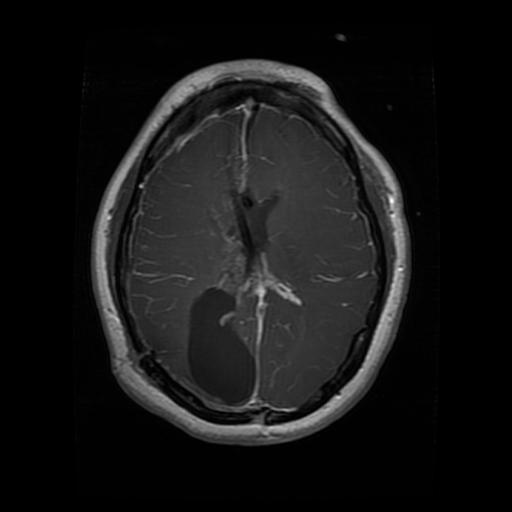

In [68]:
img = Image.open(test_path + '/0009.jpg')
img

In [69]:
print("Predicted label : ",all_lables[y_pred[count]])

Predicted label :  Glioma
